In [1]:
import json

import bz2
import regex
from tqdm import tqdm
from scipy import sparse

In [2]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
responses = []
with bz2.BZ2File('../banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [01:39, 2030.14it/s]


In [4]:
len(responses)

153499

#  Домашнее задание по NLP # 1 [100 баллов]
## Классификация по тональности 

В этом домашнем задании вам предстоит классифицировать по тональности отзывы на банки с сайта banki.ru.

Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5. 

Тексты хранятся в json-ах в массиве responses.

Посмотрим на пример отзыва:

In [5]:
responses[99]

{'city': 'г. Саратов',
 'rating_not_checked': False,
 'title': 'Карта ко вкладу',
 'num_comments': 0,
 'bank_license': 'лицензия № 880',
 'author': 'ronnichka',
 'bank_name': 'Югра',
 'datetime': '2015-06-03 20:56:57',
 'text': 'Здравствуйте! Хотела написать, что мне месяц не выдают карту ко вкладу, ссылаясь на "нам же их из Самары везут" (на секундочку 5 часов езды от нашего города). Но! Прочитала, что людям 3,5 месяцев не выдают карту, и поняла, что у меня все хорошо, пока что. И подарок мне дали, и кулер в отделении есть. Так что я, конечно, готова ждать. Правда хотелось бы не очень долго.',
 'rating_grade': 3}

## Часть 1. Анализ текстов [40/100]

1. Посчитайте количество отзывов в разных городах и на разные банки

In [6]:
res_city = {}

for i in responses:
    res_city[i['city']] = res_city[i['city']]+1 if i['city'] in res_city else 1
print(res_city)
    

{'г. Москва': 55354, 'г. Новосибирск': 2300, 'г. Ставрополь': 696, 'г. Челябинск': 1507, 'г. Волгоград': 1014, 'г. Пермь': 1163, 'г. Ростов-на-Дону': 1891, 'г. Воронеж': 1210, 'г. Таганрог (Ростовская обл.)': 8, 'г. Санкт-Петербург': 14342, 'г. Конаково': 9, 'г. Мурманск': 434, 'г. Волгодонск (Ростовская обл.)': 7, 'г. Большеречье': 2, 'г. Одинцово (Московская обл.)': 8, 'г. Салават (Республика Башкортостан)': 4, 'г. Краснодар': 1262, 'г. Кострома': 160, 'г. Нижний Новгород': 1976, 'г. Орел': 234, 'г. Саратов': 933, 'г. Казань': 1440, 'г. Реутов (Московская обл.)': 3, 'г. Ульяновск': 500, 'г. Красноярск': 1236, 'г. Хабаровск': 681, 'г. Магнитогорск (Челябинская обл.)': 16, 'г. Фролово (Волгоградская обл.)': 1, 'г. Новочеркасск': 67, 'г. Чита': 126, 'г. таганрог': 8, 'г. Йошкар-Ола': 190, 'г. Нижний Тагил': 189, 'г. Ханты-Мансийск': 48, 'г. Россия': 204, 'г. Липецк': 461, 'г. Нижнекамск (Республика Татарстан)': 5, 'г. Тюмень': 656, 'г. Москва, Санкт-Петербург': 3, 'г. Кизел': 2, 'г. Мон

In [7]:
print(len(res_city)) #всего уникальных названий городов

5824


In [8]:
res_bank_name = {}

for i in responses:
    res_bank_name[i['bank_name']] = res_bank_name[i['bank_name']]+1 if i['bank_name'] in res_bank_name else 1
print(res_bank_name)

{'Бинбанк': 1646, 'Сбербанк России': 26327, 'ОТП Банк': 3237, 'Гагаринский': 19, 'Тинькофф Банк': 5387, 'Восточный Экспресс Банк': 3138, 'ВТБ 24': 8185, 'Альфа-Банк': 10224, 'БИНБАНК кредитные карты': 1464, 'МТС Банк': 1870, 'Совкомбанк': 919, 'Россельхозбанк': 532, 'Московский Кредитный Банк': 2944, 'МДМ Банк': 776, 'Хоум Кредит Банк': 7549, 'Бенифит-Банк': 115, 'Уральский Банк Реконструкции и Развития': 532, 'Русский Стандарт': 7943, 'Лето Банк': 501, 'Петрокоммерц': 339, 'Русфинанс Банк': 723, 'Киви Банк': 1741, 'Ханты-Мансийский банк Открытие': 2158, 'Русславбанк': 715, 'Татфондбанк': 159, 'МАСТ-Банк': 208, 'Национальный Банк «Траст»': 4607, 'Военно-Промышленный Банк': 149, 'АктивКапитал Банк': 75, 'Связной Банк': 3775, 'Платежный Центр': 13, 'Московский Индустриальный Банк': 271, 'Финансовый Стандарт': 125, 'Ренессанс Кредит': 3849, 'Югра': 451, 'ЮниКредит Банк': 2488, 'Банкирский Дом': 43, 'Кредит Европа Банк': 1683, 'Тройка-Д Банк': 13, 'ДельтаКредит': 501, 'Сетелем Банк': 1351,

In [9]:
print(len(res_bank_name)) #всего уникальных названий банков

670


In [6]:
df = pd.DataFrame(responses[:10000])
df.head()

author     bank_license        bank_name            city  \
0       uhnov1  лицензия № 2562          Бинбанк       г. Москва   
1       Foryou  лицензия № 1481  Сбербанк России  г. Новосибирск   
2   Vladimir84  лицензия № 2562          Бинбанк       г. Москва   
3       643609  лицензия № 1481  Сбербанк России   г. Ставрополь   
4  anfisa-2003  лицензия № 2766         ОТП Банк    г. Челябинск   

              datetime  num_comments  rating_grade  rating_not_checked  \
0  2015-06-08 12:50:54             0           NaN               False   
1  2015-06-08 11:09:57             0           NaN               False   
2  2015-06-05 20:14:28             1           NaN               False   
3  2015-06-05 13:51:01             2           NaN               False   
4  2015-06-05 10:58:12             1           NaN               False   

                                                text  \
0  Добрый день! Я не являюсь клиентом банка и пор...   
1  Доброго дня! Являюсь держателем зарплатной кар...   
2  Здравствуйте!  Дублирую свое заявление от 03.0...   
3  Добрый день!! Я открыл расчетный счет в СберБа...   
4  04.03.2015 г. взяла кредит в вашем банке, заяв...   

                                               title  
0                                             Жалоба  
1      Не могу пользоваться услугой Сбербанк он-лайн  
2                    Двойное списание за один товар.  
3  Меняют проценты комиссии  не предупредив и не ...  
4             Верните денежные средства за страховку

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
author                10000 non-null object
bank_license          10000 non-null object
bank_name             10000 non-null object
city                  10000 non-null object
datetime              10000 non-null object
num_comments          10000 non-null int64
rating_grade          4150 non-null float64
rating_not_checked    10000 non-null bool
text                  10000 non-null object
title                 10000 non-null object
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 713.0+ KB


In [8]:
df.describe()

num_comments  rating_grade
count  10000.000000   4150.000000
mean       2.277900      1.851807
std        3.928793      1.347705
min        0.000000      1.000000
25%        0.000000      1.000000
50%        1.000000      1.000000
75%        3.000000      2.000000
max       95.000000      5.000000

In [9]:
len_data = df.text.apply(len)
len_data.describe()

count    10000.000000
mean      1385.266100
std       1198.129411
min         41.000000
25%        638.000000
50%       1047.000000
75%       1711.000000
max      12837.000000
Name: text, dtype: float64

In [10]:
df.rating_grade.fillna(0)
df.rating_grade.describe()

count    4150.000000
mean        1.851807
std         1.347705
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         5.000000
Name: rating_grade, dtype: float64

In [11]:
df.rating_grade.value_counts()

1.0    2585
2.0     660
5.0     471
3.0     311
4.0     123
Name: rating_grade, dtype: int64

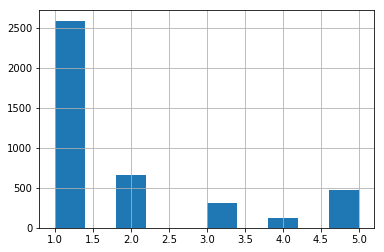

In [12]:
#гистограмма оценок
df.rating_grade.hist()

2. Постройте гистограмы длин слов в символах и в словах

In [13]:
import matplotlib.pyplot as plt
import numpy as np 
counts = df.title.value_counts()
counts = counts.head(100)
counts

Благодарность                                                32
Жалоба                                                       30
Реструктуризация                                             30
Звонки из банка                                              28
Претензия                                                    28
                                                             26
Телефонный терроризм                                         24
Некомпетентность сотрудников                                 17
Некомпетентные сотрудники                                    14
Кредитная карта                                              14
Перевыпуск карты                                             14
Звонки                                                       13
Звонки по чужому кредиту                                     13
Открытие вклада                                              13
Отвратительное обслуживание                                  12
Ужасное обслуживание                    

In [14]:
values = counts.tolist()
labels = counts.index.tolist()
y_pos = np.arange(len(labels))

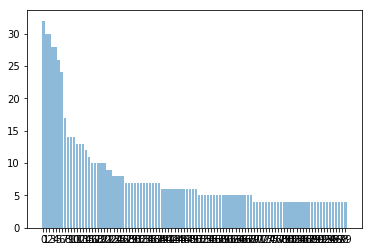

In [15]:
plt.bar(y_pos, values, align='center', alpha=0.5)
plt.xticks(y_pos, range(len(labels)))
plt.show()

In [16]:
counts1 = df.title.value_counts()

In [17]:
df_counts = pd.DataFrame(counts1)

In [18]:
df_counts.head(30).style.bar()

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


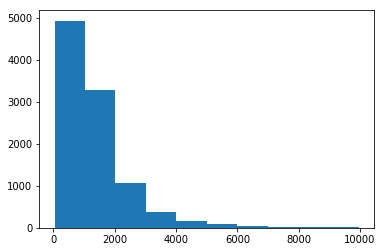

In [19]:
#Длины текстов (в символах)
fig, ax = plt.subplots()

length = len_data[len_data < 10000].tolist()

n, bins, patches = ax.hist(length)

fig.show()

3. Найдите 10 самых частых:
    * слов
    * слов без стоп-слов
    * лемм 
    * существительных

In [20]:
#Используем регулярные выражения, чтобы разбить тексты на слова
import re
regex = re.compile("[А-Яа-яЁё]+")

def words_only(text, regex=regex):
    try:
        return " ".join(regex.findall(text))
    except:
        return ""


df.text = df.text.str.lower()
df.text = df.text.apply(words_only)

df.text.iloc[0]

'добрый день я не являюсь клиентом банка и поручителем по кредитному договору а также не являюсь каким либо другим лицом письменно оформившим отношения с банком по поводу урегулирования чьей либо задолженности начиная с марта года начали приходить бесконечные письма из ооо примо коллект на мой адрес город москва уваровский переулок дом квартира с угрозами о возбуждении уголовного дела в отношении гражданина филиппова эдуарда владимировича который уклоняется от уплаты взятых им кредитов договор от года и договор от года со всей ответственностью хочу вас заверить что вышеуказанный гражданин которого вы разыскиваете мне не знаком и никогда в моем адресе не был зарегистрирован каким образом вы не удостоверившись в подлинности его документов оформили на его имя кредитный договор мне по меньшей мере не понятно и почему по вашей милости я должна переживать и бояться за себе и свое имущество письма доставляют мне серьезные неудобства нарушают мои гражданские права а также нарушают закон о защи

In [21]:
# Самые частые слова
from collections import Counter
from tqdm import tqdm_notebook as tqdm
cnt = Counter()
n_types = []
n_tokens = []
tokens = []
for index, row in tqdm(df.iterrows(), total = len(df)):
    tokens = row['text'].split()
    cnt.update(tokens)
    n_types.append(len(cnt))
    n_tokens.append(sum(cnt.values()))
for i in cnt.most_common(10):
    print(i)


('в', 75560)
('и', 60839)
('не', 49717)
('на', 41269)
('что', 36343)
('я', 33614)
('с', 28473)
('по', 22747)
('мне', 19041)
('банка', 17330)


In [22]:
from nltk.corpus import stopwords
print(stopwords.words('russian'))

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

In [23]:
mystopwords = stopwords.words('russian') + ['г', 'Добрый день', 'Здравствуйте', 'доброго', 'дня', 'добрый', 'день', 'здравствуйте', 'В', 'тут-то', 'было', 'На', 'чуть-чуть', 'это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д', '-', 'Не', 'Как', 'без', 'рэ']
def  remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""
 

In [24]:
df['text']= df.text.apply(remove_stopwords) 

In [25]:
# Самые частые слова без стоп-слов
cnt = Counter()
n_types = []
n_tokens = []
tokens = []
tokens_all = []
for index, row in tqdm(df.iterrows(), total = len(df)):
    tokens = row['text'].split()
    tokens_all.append(tokens)
    cnt.update(tokens)
    n_types.append(len(cnt))
    n_tokens.append(sum(cnt.values()))
for i in cnt.most_common(10):
    print(i)


('банка', 17330)
('банк', 13989)
('деньги', 7068)
('карты', 6059)
('карту', 5677)
('кредит', 4663)
('банке', 4175)
('заявление', 3982)
('года', 3726)
('время', 3444)


In [26]:
tokens_all

[['являюсь',
  'клиентом',
  'банка',
  'поручителем',
  'кредитному',
  'договору',
  'являюсь',
  'каким',
  'либо',
  'другим',
  'лицом',
  'письменно',
  'оформившим',
  'отношения',
  'банком',
  'поводу',
  'урегулирования',
  'чьей',
  'либо',
  'задолженности',
  'начиная',
  'марта',
  'года',
  'начали',
  'приходить',
  'бесконечные',
  'письма',
  'ооо',
  'примо',
  'коллект',
  'адрес',
  'город',
  'москва',
  'уваровский',
  'переулок',
  'дом',
  'квартира',
  'угрозами',
  'возбуждении',
  'уголовного',
  'дела',
  'отношении',
  'гражданина',
  'филиппова',
  'эдуарда',
  'владимировича',
  'который',
  'уклоняется',
  'уплаты',
  'взятых',
  'кредитов',
  'договор',
  'года',
  'договор',
  'года',
  'всей',
  'ответственностью',
  'хочу',
  'заверить',
  'вышеуказанный',
  'гражданин',
  'которого',
  'разыскиваете',
  'знаком',
  'моем',
  'адресе',
  'зарегистрирован',
  'каким',
  'образом',
  'удостоверившись',
  'подлинности',
  'документов',
  'оформили',
  

In [27]:
df.head()

author     bank_license        bank_name            city  \
0       uhnov1  лицензия № 2562          Бинбанк       г. Москва   
1       Foryou  лицензия № 1481  Сбербанк России  г. Новосибирск   
2   Vladimir84  лицензия № 2562          Бинбанк       г. Москва   
3       643609  лицензия № 1481  Сбербанк России   г. Ставрополь   
4  anfisa-2003  лицензия № 2766         ОТП Банк    г. Челябинск   

              datetime  num_comments  rating_grade  rating_not_checked  \
0  2015-06-08 12:50:54             0           NaN               False   
1  2015-06-08 11:09:57             0           NaN               False   
2  2015-06-05 20:14:28             1           NaN               False   
3  2015-06-05 13:51:01             2           NaN               False   
4  2015-06-05 10:58:12             1           NaN               False   

                                                text  \
0  являюсь клиентом банка поручителем кредитному ...   
1  являюсь держателем зарплатной карты выданной с...   
2  дублирую свое заявление можайский мною моей де...   
3  открыл расчетный счет сбербанке юр лицо одно д...   
4  взяла кредит вашем банке заявленная мною сумма...   

                                               title  
0                                             Жалоба  
1      Не могу пользоваться услугой Сбербанк он-лайн  
2                    Двойное списание за один товар.  
3  Меняют проценты комиссии  не предупредив и не ...  
4             Верните денежные средства за страховку

In [28]:
# Лемматизация
from pymystem3 import Mystem

In [29]:
m = Mystem()
def lemmatize(text, mystem=m):
    try:
        return [l for l in m.lemmatize(text) if l.isalpha()]
    except:
        return []

mystoplemmas = ['который','прошлый','сей', 'свой', 'наш', 'мочь']
def  remove_stoplemmas(text, mystoplemmas = mystoplemmas):
    try:
        return " ".join([token for token in text.split() if not token in mystoplemmas])
    except:
        return ""    
       
def preprocessing(text):
    lemmas = lemmatize(text)
    lemmas = remove_stoplemmas(lemmas)
    return(lemmas)

In [31]:
%time df['lemmas'] = df.text.apply(lambda x: preprocessing(x))

CPU times: user 4.69 s, sys: 255 ms, total: 4.95 s
Wall time: 52.2 s


In [33]:
df.head()

author     bank_license        bank_name            city  \
0       uhnov1  лицензия № 2562          Бинбанк       г. Москва   
1       Foryou  лицензия № 1481  Сбербанк России  г. Новосибирск   
2   Vladimir84  лицензия № 2562          Бинбанк       г. Москва   
3       643609  лицензия № 1481  Сбербанк России   г. Ставрополь   
4  anfisa-2003  лицензия № 2766         ОТП Банк    г. Челябинск   

              datetime  num_comments  rating_grade  rating_not_checked  \
0  2015-06-08 12:50:54             0           NaN               False   
1  2015-06-08 11:09:57             0           NaN               False   
2  2015-06-05 20:14:28             1           NaN               False   
3  2015-06-05 13:51:01             2           NaN               False   
4  2015-06-05 10:58:12             1           NaN               False   

                                                text  \
0  являюсь клиентом банка поручителем кредитному ...   
1  являюсь держателем зарплатной карты выданной с...   
2  дублирую свое заявление можайский мною моей де...   
3  открыл расчетный счет сбербанке юр лицо одно д...   
4  взяла кредит вашем банке заявленная мною сумма...   

                                               title lemmas  
0                                             Жалоба         
1      Не могу пользоваться услугой Сбербанк он-лайн         
2                    Двойное списание за один товар.         
3  Меняют проценты комиссии  не предупредив и не ...         
4             Верните денежные средства за страховку

In [36]:
#tokens_all = ','.join(tokens_all[1])
#tokens_all

'являюсь,держателем,зарплатной,карты,выданной,сбербанком,россии,году,сменила,фамилию,предоставила,банк,документы,копию,нового,паспорта,свидетельства,браке,перевыпустили,карту,фамилию,мужа,токарева,мария,александровна,девичья,секлетина,возникла,необходимость,подключить,услугу,сбербанк,онлайн,получилось,главной,странице,отображались,мои,карты,связалась,техническим,специалистом,отделения,сбербанка,котором,обслуживалась,пояснил,базе,банка,ещё,девичьей,фамилией,секлетина,предложил,выслать,сканы,необходимых,документов,выслала,оставив,контакты,звонка,дождалась,ч,з,некоторое,время,звоню,сама,объясняю,ситуацию,пробивают,базе,числюсь,секлетиной,хотя,карту,перевыпустили,фамилию,токарева,связи,истечением,срока,обслуживания,высылаю,документы,копию,паспорта,свидетельства,браке,результат,ноль,прошу,помочь,разобраться,ситуации,уважением,токарева,мария,александровна'

In [37]:
#cnt = Counter()
#n_types = []
#n_tokens = []
#tokens = []
#lemmas = []
#all_lemmas = []
#for i in tqdm(range(len(tokens_all))):
   # tokens = tokens_all.split()
    
   # lemmas.append(m.lemmatize(index))
    
   # all_lemmas.append(''.join(lemmas))
   # cnt.update(lemmas)
   # n_types.append(len(cnt))
   # n_tokens.append(sum(cnt.values()))
#for i in cnt.most_common(10):
   # print(i)

AttributeError: 'int' object has no attribute 'splitlines'

In [ ]:
#cnt = Counter()
#n_types = []
#n_tokens = []
#tokens = []
#all_lemmas = []
#for index, row in tqdm(df.iterrows(), total = 10000):
    #df['lemmas'] = df.text.apply(lambda x: preprocessing(x))
    
    #tokens = row['text'].split()
    #tokens = toktok.tokenize(df.text, return_str=True)
    #forms = predictor.predict(tokens.split())
    #lemmas  = [form.normal_form for form in forms]

   # all_lemmas.append(lemmas)
   # cnt.update(lemmas)
   # n_types.append(len(cnt))
   # n_tokens.append(sum(cnt.values()))
#for i in cnt.most_common(10):
  #  print(i)

In [ ]:
#all_lemmas

In [105]:
#tokens = toktok.tokenize(df.text, return_str=True)
#forms = predictor.predict(tokens.split())
#lemmas  = [form.normal_form for form in forms]
#print(' '.join(lemmas))

0 жалоба 1 мочь пользоваться услуга сбербанк он-лайна 2 двойной списание товар. 3 менять процент комиссия предупредить известить ... 4 вернуть денежный средство страховка 5 быть ... 6 получение уэк 7 вот поворот ! 8 о разглашение персональный данные 9 просить помощь 10 повесить кредит 11 трудность возвращение комиссия забракованный ... 12 благодарность 13 стечение обстоятельство 14 шок 15 нет зачисление платёж банкомат отп банк ! 16 звонок достать 17 режим работа неработающий 18 неожиданный неприятный информация сотрудник том ... 19 некомпетентность сотрудник банк 20 кредитный каникулы 21 клиент банк нужный ! 22 незаконный передача персональный данные 23 купить монетка память 24 монетка память 25 клиент виноватый 26 непродуманный система обслуживание 27 отсрочка 28 благодарственный письмо 29 нужный стационарный номер телефон офис ... 153469 обслуживание втб г. екатеринбург 153470 мочь идеал , многий другой 153471 очередной бесплатный сыр ... 153472 общение клиент вклад 153473 быстрый п

In [32]:
df['lemma']= df.lemma.apply(lemmas) 

AttributeError: 'DataFrame' object has no attribute 'lemma'

In [109]:
df['lemma'] = df['lemma'].apply(remove_stoplemmas) 

In [ ]:
from rnnmorph.predictor import RNNMorphPredictor

predictor = RNNMorphPredictor(language="ru")

In [30]:

cnt = Counter()
n_types = []
n_tokens = []
tokens = []
words1 = []

for index, row in tqdm(df.iterrows(), total = len(df)):
    tokens = row['lemma'].split()
    tokens = toktok.tokenize(tokens, return_str=True)
    forms = predictor.predict(tokens.split())
    lemmas  = [form.normal_form for form in forms]
    #print(' '.join(lemmas))
    
    cnt.update(tokens)
    n_types.append(len(cnt))
    n_tokens.append(sum(cnt.values()))   
for i in cnt.most_common(10):
    print(i)

KeyError: 'lemma'

In [ ]:
# Самые частые леммы
lemmata = []
for index, row in df.iterrows():
    lemmata += row['lemma'].split()
cnt = Counter(lemmata)
for i in cnt.most_common(10):
    print(i)

In [ ]:
nouns = []

for i in lemmata:
    prediction = predictor.predict(i)
    if 'pos=NOUN' in prediction:
        nouns = nouns.append(i)
    print(i(10))
        

4. Постройте кривые Ципфа и Хипса

### Закон Ципфа


В любом достаточно большом тексте ранг типа обратно пропорционален его частоте: $f = \frac{a}{r}$

$f$ – частота типа, $r$  – ранг типа, $a$  – параметр, для славянских языков – около 0.07

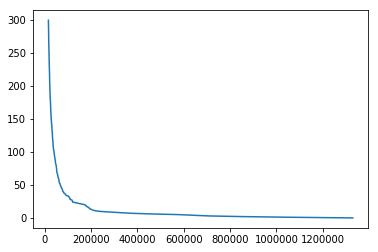

In [28]:
#кривая Ципфа
freqs = list(cnt.values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots()
ax.plot(freqs[:300], range(300))
plt.show()

### Закон Хипса

С увеличением длины текста (количества токенов), количество типов увеличивается в соответствии с законом: $|V| = K*N^b$


$N$  –  число токенов, $|V|$  – количество типов в словаре, $K, b$  –  параметры, обычно $K \in [10,100], b \in [0.4, 0.6]$

In [ ]:
#кривая Хипса
fig, ax = plt.subplots()
ax.plot(n_types, n_tokens)
plt.show()

5. Ответьте на следующие вопросы:
    * какое слово встречается чаще, "сотрудник" или "клиент"?
    * сколько раз встречается слова "мошенничество" и "доверие"?

In [ ]:
#re.findall(pattern, string) - возвращает все вхождения pattern в string в виде списка

employee = re.findall(r'сотрудник', df['lemma'])
print(len(employee))

client = re.findall(r'клиент', df['lemma'])
print(len(client))

if len(employee) > len(client) :
    print('Слово "сотрудник" встречается ',len(employee), 'раз, это чаще, чем слово "клиент", которое встречается ', len(client), ' раз.')
else:
    print('Слово "клиент" встречается ',len(client), 'раз, это чаще, чем слово "сотрудник", которое встречается ', len(employee), ' раз.')

    
fraud = re.findall(r'мошенничество', df['lemma'])
print(len(fraud))

trust = re.findall(r'доверие', df['lemma'])
print(len(trust))

In [33]:
s = 0
k = 0
m = 0
d = 0

for index, row in tqdm(df.iterrows(), total = len(df)):
    tokens = row['text'].split()
    if 'сотрудник' in tokens: 
        s +=1
    if 'клиент' in tokens: 
        k +=1
    if 'мошенничество' in tokens: 
        m +=1
    if 'доверие' in tokens: 
        d +=1   
    
if s > k :
    print('Слово "сотрудник" встречается ',s, 'раз, это чаще, чем слово "клиент", которое встречается ', k, ' раз.')

if s < k :
    print('Слово "клиент" встречается ',k, 'раз, это чаще, чем слово "сотрудник", которое встречается ', s, ' раз.')    

print('Cлово "мошенничество" встречается ', m, ' раз')
print('Cлово "доверие" встречается', d, ' раз')


Слово "сотрудник" встречается  20202 раз, это чаще, чем слово "клиент", которое встречается  15214  раз.
Cлово "мошенничество" встречается  1016  раз
Cлово "доверие" встречается 1082  раз


6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

## Часть 2. Тематическое моделирование [20/100]

1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.
2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?

Эта часть задания может быть сделана с использованием gensim. 

In [35]:
from gensim import corpora, models
import gensim

In [36]:
dictionary = corpora.Dictionary(df.lemmas)
corpus = [dictionary.doc2bow(text) for text in df.lemmas]

TypeError: doc2bow expects an array of unicode tokens on input, not a single string

In [ ]:
%time ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=5, id2word = dictionary, passes=20)

In [ ]:
ldamodel.print_topics(num_topics=5, num_words=4)

In [ ]:
import pyLDAvis.gensim
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(vis)

## Часть 3. Классификация текстов [40/100]

Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5). 

1.  Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте ```sklearn.model_selection.train_test_split``` для разделения множества отобранных документов на обучающее и тестовое. 
2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных $n$-грам. 
3. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
* 1-ый вариант: $tf-idf$ преобразование (```sklearn.feature_extraction.text.TfidfTransformer```) и сингулярное разложение (оно же – латентый семантический анализ) (```sklearn.decomposition.TruncatedSVD```), 
* 2-ой вариант: тематические модели LDA (```sklearn.decomposition.LatentDirichletAllocation```). 

Используйте accuracy и F-measure для оценки качества классификации. 

Ниже написан примерный Pipeline для классификации текстов. 

Эта часть задания может быть сделана с использованием sklearn. 

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# !!! На каждом этапе Pipeline нужно указать свои параметры
# 1-ый вариант: tf-idf + LSI
# 2-ой вариант: LDA

# clf = Pipeline([
#     ('vect', CountVectorizer(analyzer = 'char', ngram_range={4,6})),
#     ('clf', RandomForestClassifier()),
# ])



clf = Pipeline([ 
    ('vect', CountVectorizer()), 
    ('tfidf', TfidfTransformer()), 
    ('tm', TruncatedSVD()), 
    ('clf', RandomForestClassifier())
])


NameError: name 'CountVectorizer' is not defined